In [1]:
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import json
from tqdm import tqdm
import random
from datetime import datetime
import os

In [2]:
def calculate_metrics(author_data):
    """Calculate metrics for an author"""
    if not author_data or "papers" not in author_data:
        return {}
    
    name = author_data.get("name", "")
    author_id = author_data.get("authorId", "")
    papers = author_data.get("papers", [])
    
    # Initialize the metrics dictionary
    metrics = {
        "author_id": author_id,
        "name": name,
        "total_paper_count": author_data.get("paperCount", 0),
        "total_citation_count": author_data.get("citationCount", 0),
        "h_index": author_data.get("hIndex", 0)
    }
    
    # Publication years
    years = [p.get("year", 0) for p in papers if p.get("year")]
    first_publication_year = min(years) if years else None
    last_publication_year = max(years) if years else None
    
    # Calculate career span
    career_span = last_publication_year - first_publication_year + 1 if first_publication_year and last_publication_year else 0
    
    # Average papers per year
    avg_papers_per_year = metrics["total_paper_count"] / career_span if career_span > 0 else 0
    
    citations_per_paper = metrics["total_citation_count"] / metrics["total_paper_count"] if metrics["total_paper_count"] > 0 else 0 
    
    # Update metrics with career information
    metrics.update({
        "first_publication_year": first_publication_year,
        "last_publication_year": last_publication_year,
        "career_span": career_span,
        "avg_papers_per_year": avg_papers_per_year,
        "citations_per_paper": citations_per_paper
    })
    
    # Calculate authorship metrics
    first_author_count = 0
    last_author_count = 0
    single_author_count = 0
    
    for paper in papers:
        authors = paper.get("authors", [])
        if not authors:
            continue
        
        # Find the researcher in the author list
        researcher_positions = [i for i, author in enumerate(authors) 
                               if author.get("authorId") == author_id]
        
        if not researcher_positions:
            continue
            
        position = researcher_positions[0]  # Use the first instance if multiple
        
        # Count different positions
        if len(authors) == 1:
            single_author_count += 1
        elif position == 0:
            first_author_count += 1
        elif position == len(authors) - 1:
            last_author_count += 1
    
    # Update metrics with authorship information
    metrics.update({
        "first_author_count": first_author_count,
        "last_author_count": last_author_count,
        "single_author_count": single_author_count
    })
    
    first_author_ratio = first_author_count / metrics["total_paper_count"] if metrics["total_paper_count"] > 0 else 0
    last_author_ratio = last_author_count / metrics["total_paper_count"] if metrics["total_paper_count"] > 0 else 0
    single_author_ratio = single_author_count / metrics["total_paper_count"] if metrics["total_paper_count"] > 0 else 0
    # Update metrics with author ratios
    metrics.update({
        "first_author_ratio": first_author_ratio,
        "last_author_ratio": last_author_ratio,
        "single_author_ratio": single_author_ratio
    })
    
    # Calculate venue diversity and conference-journal ratio
    venues = []
    venue_types = []
    
    for paper in papers:
        # Get structured publication venue information
        pub_venue = paper.get("publicationVenue", {})
        if pub_venue:
            venue_name = pub_venue.get("name")
            venue_type = pub_venue.get("type")
            
            if venue_name:
                venues.append(venue_name)
                
            if venue_type:
                venue_types.append(venue_type)
        # Fallback to paper.venue if publicationVenue isn't available
        elif paper.get("venue"):
            venues.append(paper.get("venue"))
    
    # Process venue information
    if venues:
        venue_counter = Counter(venues)
        metrics["mode_venue"] = venue_counter.most_common(1)[0][0] if venue_counter else ""
        metrics["unique_venues"] = len(venue_counter)
        
        # Calculate venue diversity using Shannon entropy
        import math
        total_venues = sum(venue_counter.values())
        shannon_entropy = 0
        for count in venue_counter.values():
            p = count / total_venues
            if p > 0:
                shannon_entropy -= p * math.log(p)
        
        # Normalize by maximum possible entropy
        max_entropy = math.log(len(venue_counter)) if len(venue_counter) > 0 else 0
        metrics["venue_diversity"] = shannon_entropy / max_entropy if max_entropy > 0 else 0
    else:
        metrics["mode_venue"] = ""
        metrics["unique_venues"] = 0
        metrics["venue_diversity"] = 0
    
    # Calculate conference vs journal ratio
    if venue_types:
        type_counter = Counter(venue_types)
        
        # Look for terms related to conferences and journals
        conf_count = type_counter.get("conference", 0)
        journal_count = type_counter.get("journal", 0)
        
        # Add 1 to avoid division by zero
        metrics['conference_journal_ratio'] = (conf_count + 1) / (journal_count + 1)
    else:
        metrics['conference_journal_ratio'] = 0
    
    return metrics

In [3]:
import glob

def recompute_metrics_from_raw_data(raw_data_dir="raw_researcher_data1", output_file="recalculated_survey.csv"):
    """
    Recompute metrics from existing raw data files without fetching any new data
    
    Args:
        raw_data_dir: Directory containing researcher JSON data files
        output_file: Path to save the recomputed metrics
        
    Returns:
        DataFrame with recomputed researcher metrics
    """
    all_metrics = []
    
    # Get all JSON files in the raw data directory
    researcher_files = glob.glob(os.path.join(raw_data_dir, "*.json"))
    print(f"Found {len(researcher_files)} researcher data files")
    
    for researcher_file in tqdm(researcher_files):
        researcher_id = os.path.basename(researcher_file).replace(".json", "")
        
        try:
            # Load existing data
            with open(researcher_file, 'r') as f:
                researcher_data = json.load(f)
                
            # Recalculate metrics
            metrics = calculate_metrics(researcher_data)
            
            if metrics:
                all_metrics.append(metrics)
                
        except Exception as e:
            print(f"Error processing researcher {researcher_id}: {e}")
    
    # Create DataFrame with results
    metrics_df = pd.DataFrame(all_metrics)
    
    # Save to CSV
    metrics_df.to_csv(output_file, index=False)
    print(f"Recomputed metrics saved to {output_file}")
    
    return metrics_df

In [4]:
metrics_new = recompute_metrics_from_raw_data()
metrics_new.head()

Found 1000 researcher data files


100%|██████████| 1000/1000 [00:00<00:00, 1372.99it/s]


Recomputed metrics saved to recalculated_survey.csv


,author_id,name,total_paper_count,total_citation_count,h_index,first_publication_year,last_publication_year,career_span,avg_papers_per_year,citations_per_paper,first_author_count,last_author_count,single_author_count,first_author_ratio,last_author_ratio,single_author_ratio,mode_venue,unique_venues,venue_diversity,conference_journal_ratio
0,87863676,Simon Tannert,7,137,4,2015,2023,9,0.777778,19.571429,1,0,0,0.142857,0.000000,0.000000,LIMO,5,1.000000,5.000000
1,49178343,Jie Zhou,826,16280,58,2021,2024,4,206.500000,19.709443,87,90,6,0.105327,0.108959,0.007264,Social Science Research Network,334,0.960610,0.122396
2,1829350,Riccardo Miotto,62,7320,31,2008,2023,16,3.875000,118.064516,13,5,0,0.209677,0.080645,0.000000,medRxiv,34,0.962600,0.379310
3,2934336,Loïc Barrault,104,9293,31,2005,2024,20,5.200000,89.355769,9,16,7,0.086538,0.153846,0.067308,Conference on Machine Translation,38,0.890885,5.090909
4,3460489,Amir Pouran Ben Veyseh,41,2029,19,2016,2023,8,5.125000,49.487805,28,0,1,0.682927,0.000000,0.024390,Conference on Empirical Methods in Natural Lan...,19,0.939622,6.750000


In [5]:
metrics_new['leadership_ratio'] = metrics_new['first_author_ratio'] + metrics_new['last_author_ratio']
metrics_new.head()

,author_id,name,total_paper_count,total_citation_count,h_index,first_publication_year,last_publication_year,career_span,avg_papers_per_year,citations_per_paper,...,last_author_count,single_author_count,first_author_ratio,last_author_ratio,single_author_ratio,mode_venue,unique_venues,venue_diversity,conference_journal_ratio,leadership_ratio
0,87863676,Simon Tannert,7,137,4,2015,2023,9,0.777778,19.571429,...,0,0,0.142857,0.000000,0.000000,LIMO,5,1.000000,5.000000,0.142857
1,49178343,Jie Zhou,826,16280,58,2021,2024,4,206.500000,19.709443,...,90,6,0.105327,0.108959,0.007264,Social Science Research Network,334,0.960610,0.122396,0.214286
2,1829350,Riccardo Miotto,62,7320,31,2008,2023,16,3.875000,118.064516,...,5,0,0.209677,0.080645,0.000000,medRxiv,34,0.962600,0.379310,0.290323
3,2934336,Loïc Barrault,104,9293,31,2005,2024,20,5.200000,89.355769,...,16,7,0.086538,0.153846,0.067308,Conference on Machine Translation,38,0.890885,5.090909,0.240385
4,3460489,Amir Pouran Ben Veyseh,41,2029,19,2016,2023,8,5.125000,49.487805,...,0,1,0.682927,0.000000,0.024390,Conference on Empirical Methods in Natural Lan...,19,0.939622,6.750000,0.682927


### Clustering

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [8]:
df = metrics_new.copy()

# Select features for clustering
# Focus on key metrics that define researcher profiles
selected_features = [
    'h_index', 'total_citation_count', 'total_paper_count', 
    'career_span', 'citations_per_paper', 'first_author_ratio', 
    'last_author_ratio', 'venue_diversity', 'conference_journal_ratio'
]

X = df[selected_features].copy()

In [17]:
# Check for any NaN values and handle them
print("\nMissing values in selected features:")
print(X.isnull().sum())

# Handle NaN values if any (replace with median)
X = X.fillna(X.median())

# Data preprocessing
# Apply log transformation to highly skewed metrics
for col in ['total_citation_count', 'citations_per_paper']:
    if col in X.columns:
        # Add small constant to avoid log(0)
        X[col] = np.log1p(X[col])

# Standardize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
# Using 2 components initially for easy visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Print explained variance ratio
print("\nExplained variance ratio with 2 PCA components:")
print(pca.explained_variance_ratio_)
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

pca_components = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'], 
    index=selected_features
)
print("\nPCA components loadings:")
print(pca_components)


Missing values in selected features:
h_index                     0
total_citation_count        0
total_paper_count           0
career_span                 0
citations_per_paper         0
first_author_ratio          0
last_author_ratio           0
venue_diversity             0
conference_journal_ratio    0
dtype: int64

Explained variance ratio with 2 PCA components:
[0.35449537 0.16056987]
Total explained variance: 0.5151

PCA components loadings:
                               PC1       PC2
h_index                   0.513104 -0.025791
total_citation_count      0.470212 -0.321125
total_paper_count         0.474279  0.130921
career_span               0.327754  0.250426
citations_per_paper       0.132599 -0.676549
first_author_ratio       -0.228033 -0.120987
last_author_ratio         0.318649  0.375567
venue_diversity           0.051229  0.103209
conference_journal_ratio  0.097559 -0.438521


In [18]:
# Try 3 components to see if we get better variance explained
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_scaled)
print("\nExplained variance ratio with 3 PCA components:")
print(pca3.explained_variance_ratio_)
print(f"Total explained variance: {sum(pca3.explained_variance_ratio_):.4f}")

# Let's see how the features contribute to the principal components
pca_components = pd.DataFrame(
    pca3.components_.T, 
    columns=['PC1', 'PC2', 'PC3'], 
    index=selected_features
)
print("\nPCA components loadings:")
print(pca_components)


Explained variance ratio with 3 PCA components:
[0.35449537 0.16056987 0.14203644]
Total explained variance: 0.6571

PCA components loadings:
                               PC1       PC2       PC3
h_index                   0.513104 -0.025791 -0.041670
total_citation_count      0.470212 -0.321125 -0.121411
total_paper_count         0.474279  0.130921 -0.022502
career_span               0.327754  0.250426 -0.212672
citations_per_paper       0.132599 -0.676549  0.269277
first_author_ratio       -0.228033 -0.120987 -0.493891
last_author_ratio         0.318649  0.375567  0.231673
venue_diversity           0.051229  0.103209 -0.698675
conference_journal_ratio  0.097559 -0.438521 -0.282010


Silhouette score for k=2: 0.3738
Silhouette score for k=3: 0.4112
Silhouette score for k=4: 0.3352
Silhouette score for k=5: 0.3266
Silhouette score for k=6: 0.3057
Silhouette score for k=7: 0.2738
Silhouette score for k=8: 0.2770
Silhouette score for k=9: 0.2810

Analyzing optimal number of clusters...

Optimal number of clusters based on silhouette score: 3


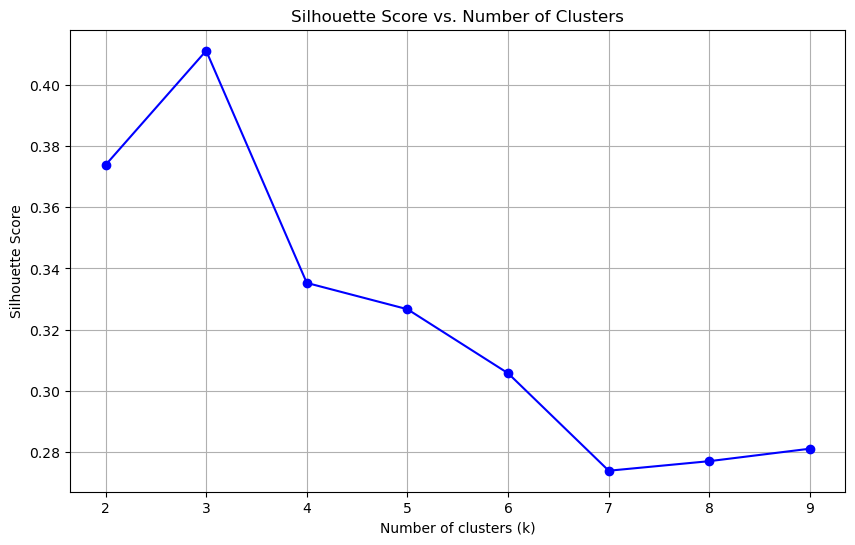

In [19]:
# Determine optimal number of clusters using silhouette score
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca3)
    silhouette_avg = silhouette_score(X_pca3, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Silhouette score for k={k}: {silhouette_avg:.4f}")

# Plot silhouette scores to find optimal k
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
# We'll see the plot in the output
print("\nAnalyzing optimal number of clusters...")

# Based on silhouette analysis, apply KMeans clustering with the optimal k
# For this example, let's say optimal k is 4 (will be determined by the analysis)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters based on silhouette score: {optimal_k}")

In [21]:
# Apply K-means clustering with the optimal k on the 3D PCA data
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca3)  # Use X_pca3 instead of X_pca

# Add cluster labels to the original dataframe
df['cluster'] = cluster_labels


Creating cluster visualization in 3D PCA space...


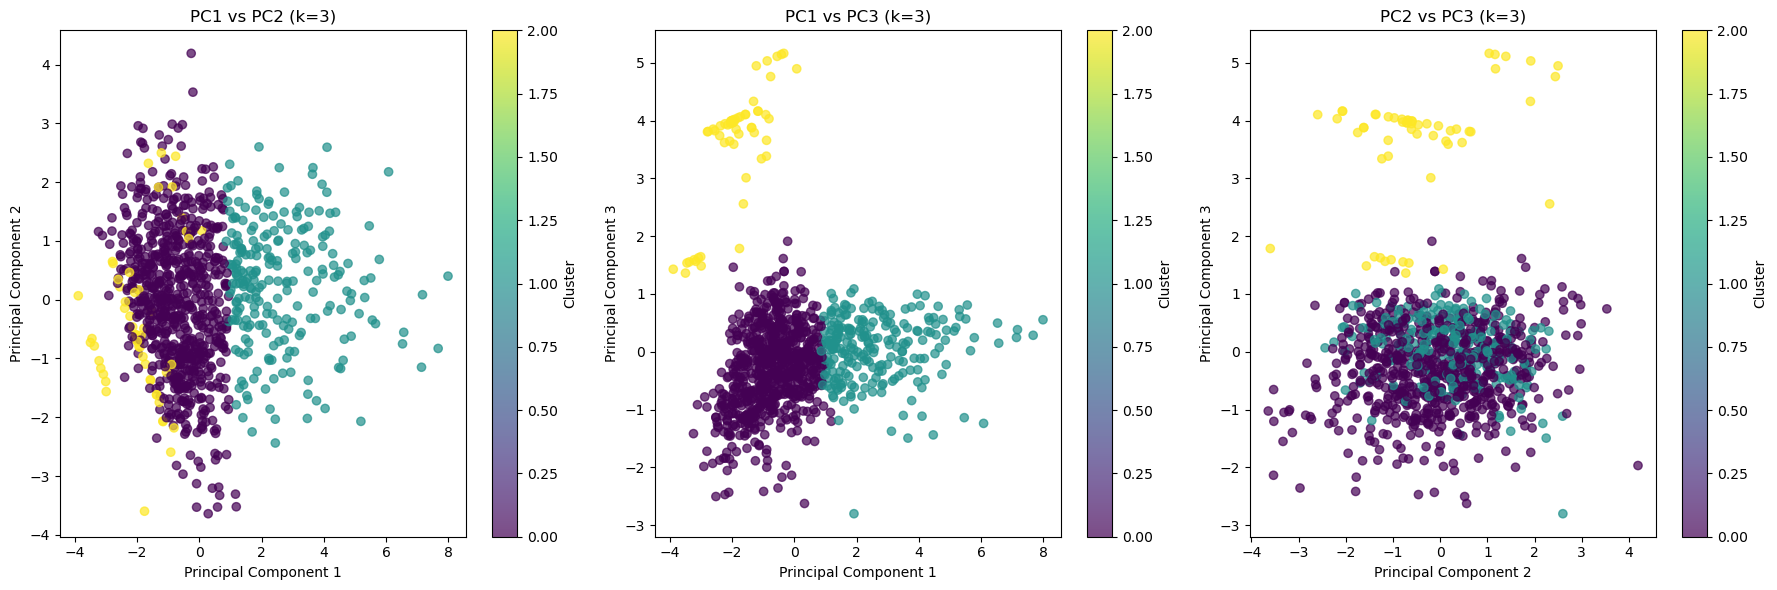

In [22]:
# Visualize the clusters with multiple 2D plots of the 3D PCA space
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PC1 vs PC2
scatter1 = axes[0].scatter(X_pca3[:, 0], X_pca3[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
axes[0].set_title(f'PC1 vs PC2 (k={optimal_k})')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# PC1 vs PC3
scatter2 = axes[1].scatter(X_pca3[:, 0], X_pca3[:, 2], c=cluster_labels, cmap='viridis', alpha=0.7)
axes[1].set_title(f'PC1 vs PC3 (k={optimal_k})')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 3')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

# PC2 vs PC3
scatter3 = axes[2].scatter(X_pca3[:, 1], X_pca3[:, 2], c=cluster_labels, cmap='viridis', alpha=0.7)
axes[2].set_title(f'PC2 vs PC3 (k={optimal_k})')
axes[2].set_xlabel('Principal Component 2')
axes[2].set_ylabel('Principal Component 3')
plt.colorbar(scatter3, ax=axes[2], label='Cluster')

plt.tight_layout()
print("\nCreating cluster visualization in 3D PCA space...")

In [23]:
# Analyze cluster characteristics
cluster_stats = df.groupby('cluster')[selected_features].mean()
print("\nCluster centers (mean values for each feature):")
print(cluster_stats)

# Calculate percentiles within each cluster for h-index
for cluster_id in range(optimal_k):
    cluster_df = df[df['cluster'] == cluster_id]
    
    if len(cluster_df) > 0:
        low_threshold = cluster_df['h_index'].quantile(0.25)
        med_threshold = cluster_df['h_index'].median()
        high_threshold = cluster_df['h_index'].quantile(0.75)
        
        print(f"\nCluster {cluster_id} Percentiles:")
        print(f"Low (25th): h-index <= {low_threshold:.2f}")
        print(f"Medium (50th): h-index ~ {med_threshold:.2f}")
        print(f"High (75th): h-index >= {high_threshold:.2f}")
        
        # Sample researchers from each level
        high_impact = cluster_df[cluster_df['h_index'] >= high_threshold].sample(min(1, len(cluster_df[cluster_df['h_index'] >= high_threshold])))
        medium_impact = cluster_df[(cluster_df['h_index'] >= med_threshold) & (cluster_df['h_index'] < high_threshold)].sample(min(1, len(cluster_df[(cluster_df['h_index'] >= med_threshold) & (cluster_df['h_index'] < high_threshold)])))
        low_impact = cluster_df[cluster_df['h_index'] <= low_threshold].sample(min(1, len(cluster_df[cluster_df['h_index'] <= low_threshold])))
        
        print("\nSample researchers from each level:")
        print("High impact:")
        print(high_impact[['name', 'h_index', 'total_citation_count', 'career_span']].head(1))
        print("Medium impact:")
        print(medium_impact[['name', 'h_index', 'total_citation_count', 'career_span']].head(1))
        print("Low impact:")
        print(low_impact[['name', 'h_index', 'total_citation_count', 'career_span']].head(1))


Cluster centers (mean values for each feature):
           h_index  total_citation_count  total_paper_count  career_span  \
cluster                                                                    
0        11.831461           2025.002809          32.893258    12.266854   
1        49.844828          22067.137931         240.883621    31.051724   
2         1.321429            356.535714           1.875000     2.750000   

         citations_per_paper  first_author_ratio  last_author_ratio  \
cluster                                                               
0                  92.865474            0.271440           0.125614   
1                 100.977950            0.134470           0.384838   
2                 252.502694            0.201833           0.160166   

         venue_diversity  conference_journal_ratio  
cluster                                             
0               0.927810                  3.201894  
1               0.857877                  3.725385  
2 

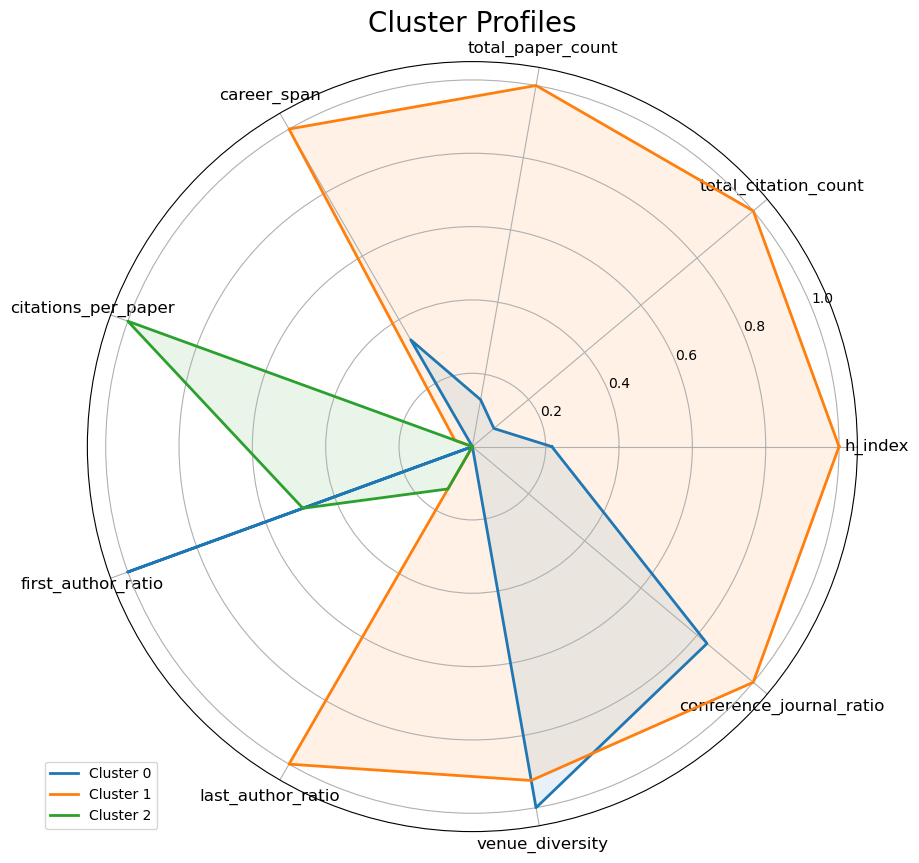

In [24]:
# Create radar chart for cluster profiles
radar_fig = radar_chart(df, cluster_stats, optimal_k)


Created 3D visualization of clusters


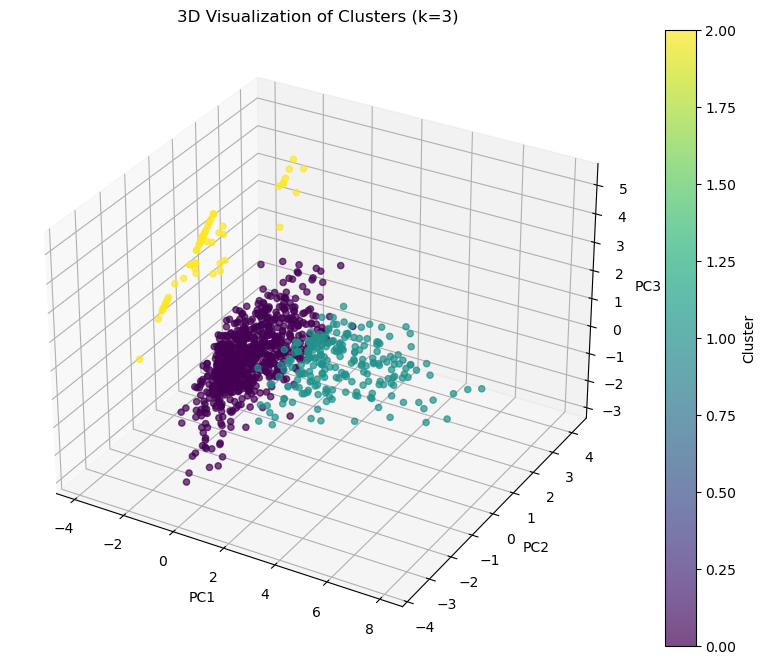

In [25]:
# Optional: Create a 3D visualization if you have a library that supports it
try:
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(
        X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2],
        c=cluster_labels, cmap='viridis', alpha=0.7
    )
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(f'3D Visualization of Clusters (k={optimal_k})')
    
    plt.colorbar(scatter, label='Cluster')
    print("\nCreated 3D visualization of clusters")
except:
    print("\nSkipping 3D visualization (requires mpl_toolkits)")

In [26]:
import plotly.express as px
import plotly.graph_objects as go

# Create the 3D scatter plot with hover information
fig = px.scatter_3d(
    # Supply the dataframe with PCA coordinates joined with researcher info
    data_frame=pd.DataFrame({
        'PC1': X_pca3[:, 0],
        'PC2': X_pca3[:, 1], 
        'PC3': X_pca3[:, 2],
        'cluster': cluster_labels,
        'name': df['name'],
        'h_index': df['h_index'],
        'citations': df['total_citation_count'],
        'career_span': df['career_span']
    }),
    x='PC1', 
    y='PC2', 
    z='PC3',
    color='cluster',
    hover_name='name',  # This will display the name when hovering
    hover_data=['h_index', 'citations', 'career_span'],  # Additional info on hover
    labels={'cluster': 'Cluster'},
    title=f'Interactive 3D Visualization of Researcher Clusters (k={optimal_k})'
)

# Customize the appearance
fig.update_traces(marker=dict(size=5, opacity=0.7))

# Make the plot more interactive
fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

# Display the interactive plot
fig.show()


Creating cluster visualization...


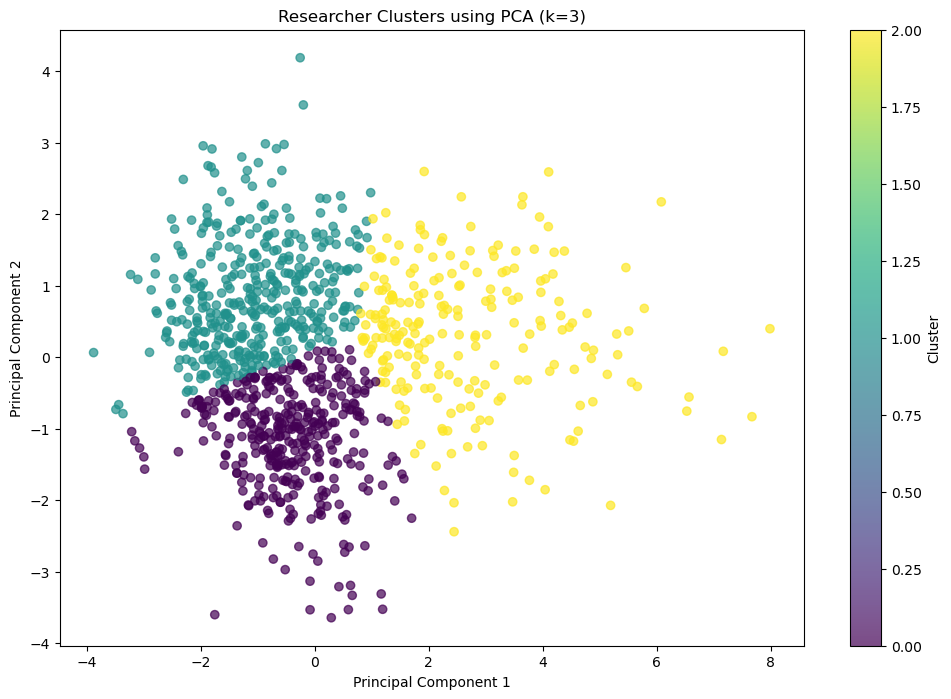

In [ ]:
# # Apply K-means clustering with the optimal k
# kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# cluster_labels = kmeans.fit_predict(X_pca)

# # Add cluster labels to the original dataframe
# df['cluster'] = cluster_labels

# # Visualize the clusters in 2D PCA space
# plt.figure(figsize=(12, 8))
# scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
# plt.colorbar(scatter, label='Cluster')
# plt.title(f'Researcher Clusters using PCA (k={optimal_k})')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# # We'll see the plot in the output
# print("\nCreating cluster visualization...")

In [ ]:
# # Analyze cluster characteristics
# cluster_stats = df.groupby('cluster')[selected_features].mean()
# print("\nCluster centers (mean values for each feature):")
# print(cluster_stats)

# # Calculate percentiles within each cluster for h-index (as a primary impact metric)
# for cluster_id in range(optimal_k):
#     cluster_df = df[df['cluster'] == cluster_id]
    
#     if len(cluster_df) > 0:
#         low_threshold = cluster_df['h_index'].quantile(0.25)
#         med_threshold = cluster_df['h_index'].median()
#         high_threshold = cluster_df['h_index'].quantile(0.75)
        
#         print(f"\nCluster {cluster_id} Percentiles:")
#         print(f"Low (25th): h-index <= {low_threshold:.2f}")
#         print(f"Medium (50th): h-index ~ {med_threshold:.2f}")
#         print(f"High (75th): h-index >= {high_threshold:.2f}")
        
#         # Sample researchers from each level
#         high_impact = cluster_df[cluster_df['h_index'] >= high_threshold].sample(min(1, len(cluster_df[cluster_df['h_index'] >= high_threshold])))
#         medium_impact = cluster_df[(cluster_df['h_index'] >= med_threshold) & (cluster_df['h_index'] < high_threshold)].sample(min(1, len(cluster_df[(cluster_df['h_index'] >= med_threshold) & (cluster_df['h_index'] < high_threshold)])))
#         low_impact = cluster_df[cluster_df['h_index'] <= low_threshold].sample(min(1, len(cluster_df[cluster_df['h_index'] <= low_threshold])))
        
#         print("\nSample researchers from each level:")
#         print("High impact:")
#         print(high_impact[['name', 'h_index', 'total_citation_count', 'career_span']].head(1))
#         print("Medium impact:")
#         print(medium_impact[['name', 'h_index', 'total_citation_count', 'career_span']].head(1))
#         print("Low impact:")
#         print(low_impact[['name', 'h_index', 'total_citation_count', 'career_span']].head(1))




Cluster centers (mean values for each feature):
           h_index  total_citation_count  total_paper_count  career_span  \
cluster                                                                    
0        11.041667           1865.364583          30.649740    11.597656   
1        49.922414          22192.862069         240.823276    30.969828   

         citations_per_paper  first_author_ratio  last_author_ratio  \
cluster                                                               
0                 103.993314            0.265912             0.1289   
1                 102.674083            0.135968             0.3823   

         venue_diversity  conference_journal_ratio  
cluster                                             
0               0.860248                  2.968058  
1               0.857576                  3.858057  

Cluster 0 Percentiles:
Low (25th): h-index <= 4.75
Medium (50th): h-index ~ 9.00
High (75th): h-index >= 16.00

Sample researchers from each level:



Creating radar chart of cluster profiles...

Creating scatter plot matrix for key features...

Cluster Interpretations:

Cluster 0:
Distinguishing characteristics:
- total_citation_count: 71.7% lower than average
- total_paper_count: 61.4% lower than average
- h_index: 45.0% lower than average
Number of researchers: 768 (76.8% of total)

Cluster 1:
Distinguishing characteristics:
- total_citation_count: 237.2% higher than average
- total_paper_count: 203.3% higher than average
- h_index: 148.8% higher than average
Number of researchers: 232 (23.2% of total)

Final selection of representative researchers:
               name  cluster impact_level  h_index  total_citation_count  \
0        Heike Adel        0         high       21                  1799   
1     Martin Müller        0       medium       11                   787   
2  Morgan Funtowicz        0          low        2                  1884   
3         G. Savova        1         high       58                 11423   
4      

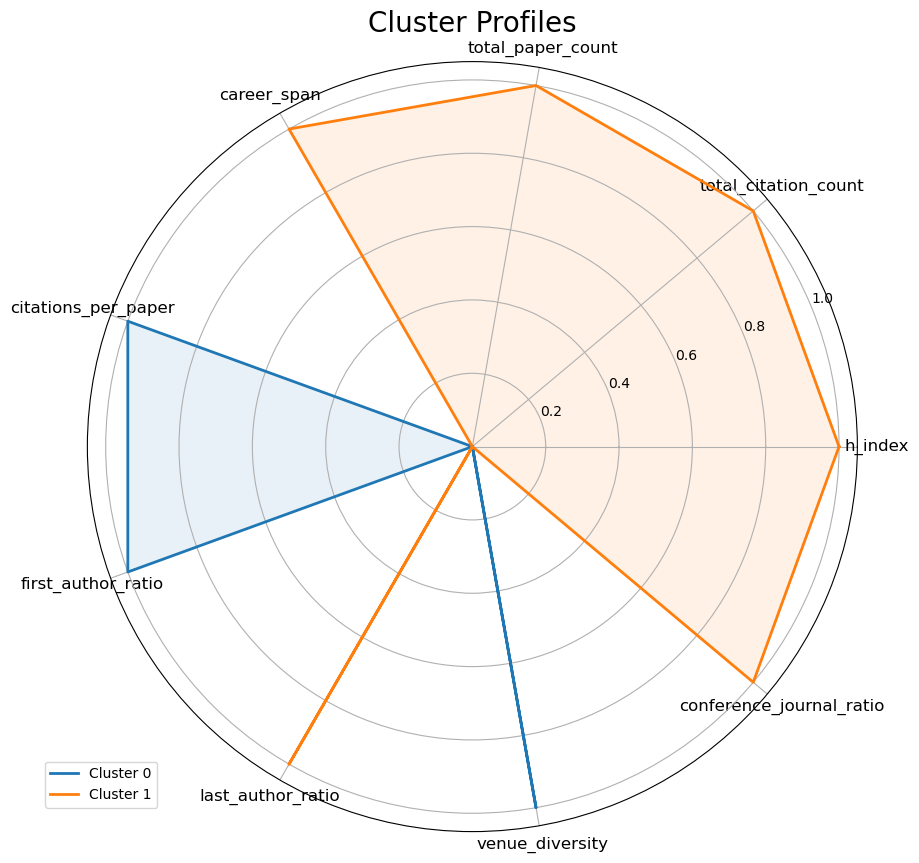

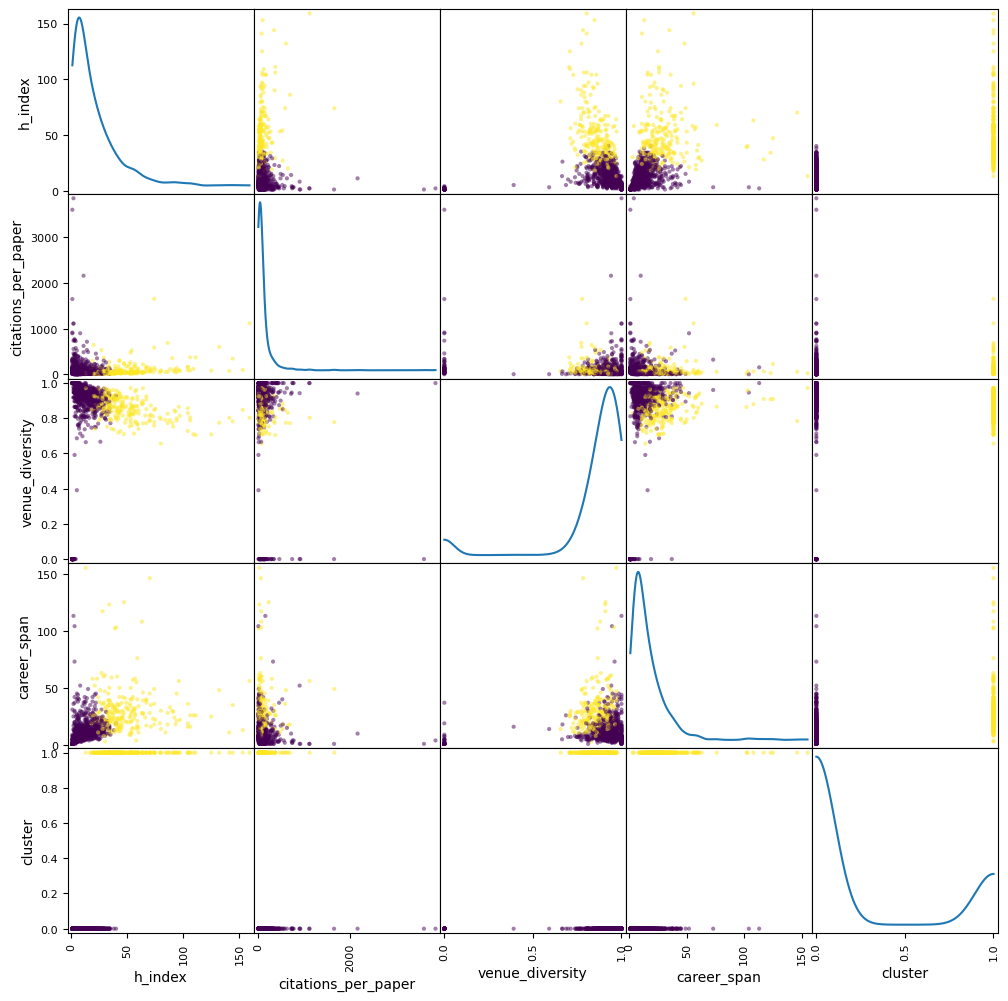

In [ ]:
# # Create a radar chart to visualize cluster profiles
# def radar_chart(df, cluster_stats, n_clusters):
#     # Normalize the cluster statistics for radar chart
#     norm_stats = (cluster_stats - cluster_stats.min()) / (cluster_stats.max() - cluster_stats.min())
    
#     # Set up the radar chart
#     categories = norm_stats.columns
#     n = len(categories)
    
#     # Create angles for each feature
#     angles = np.linspace(0, 2*np.pi, n, endpoint=False).tolist()
#     angles += angles[:1]  # Close the loop
    
#     # Create figure
#     fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
#     # Add feature labels
#     plt.xticks(angles[:-1], categories, size=12)
    
#     # Plot each cluster
#     for i in range(n_clusters):
#         values = norm_stats.iloc[i].values.tolist()
#         values += values[:1]  # Close the loop
#         ax.plot(angles, values, linewidth=2, label=f'Cluster {i}')
#         ax.fill(angles, values, alpha=0.1)
    
#     # Add legend
#     plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
#     plt.title('Cluster Profiles', size=20)
    
#     return fig

# # Create radar chart for cluster profiles
# print("\nCreating radar chart of cluster profiles...")
# radar_fig = radar_chart(df, cluster_stats, optimal_k)

# # Create a scatter plot matrix to see relationships between key variables
# key_features = ['h_index', 'citations_per_paper', 'venue_diversity', 'career_span']
# print("\nCreating scatter plot matrix for key features...")
# scatter_matrix = pd.plotting.scatter_matrix(df[key_features + ['cluster']], 
#                                              figsize=(12, 12), 
#                                              c=df['cluster'],
#                                              cmap='viridis',
#                                              diagonal='kde')

# # Interpret the clusters based on their profiles
# print("\nCluster Interpretations:")
# for i in range(optimal_k):
#     print(f"\nCluster {i}:")
#     # Get top 3 distinguishing features for this cluster
#     cluster_profile = cluster_stats.loc[i]
#     # Compare to overall average
#     overall_avg = df[selected_features].mean()
#     differences = (cluster_profile - overall_avg) / overall_avg
#     top_features = differences.abs().nlargest(3)
    
#     print("Distinguishing characteristics:")
#     for feat in top_features.index:
#         direction = "higher" if differences[feat] > 0 else "lower"
#         print(f"- {feat}: {abs(differences[feat])*100:.1f}% {direction} than average")
    
#     # Count researchers in this cluster
#     count = (df['cluster'] == i).sum()
#     print(f"Number of researchers: {count} ({count/len(df)*100:.1f}% of total)")

# # Final selected researchers from each cluster at different impact levels
# selected_researchers = []
# for cluster_id in range(optimal_k):
#     cluster_df = df[df['cluster'] == cluster_id]
    
#     if len(cluster_df) > 0:
#         # Get percentiles
#         low_threshold = cluster_df['h_index'].quantile(0.25)
#         med_threshold = cluster_df['h_index'].median()
#         high_threshold = cluster_df['h_index'].quantile(0.75)
        
#         # Select candidates from each level
#         high = cluster_df[cluster_df['h_index'] >= high_threshold].sample(min(1, len(cluster_df[cluster_df['h_index'] >= high_threshold])))
#         med = cluster_df[(cluster_df['h_index'] >= med_threshold) & (cluster_df['h_index'] < high_threshold)].sample(min(1, len(cluster_df[(cluster_df['h_index'] >= med_threshold) & (cluster_df['h_index'] < high_threshold)])))
#         low = cluster_df[cluster_df['h_index'] <= low_threshold].sample(min(1, len(cluster_df[cluster_df['h_index'] <= low_threshold])))
        
#         for df_sample, level in [(high, 'high'), (med, 'medium'), (low, 'low')]:
#             if not df_sample.empty:
#                 for _, row in df_sample.iterrows():
#                     selected_researchers.append({
#                         'name': row['name'],
#                         'cluster': cluster_id,
#                         'impact_level': level,
#                         'h_index': row['h_index'],
#                         'total_citation_count': row['total_citation_count'],
#                         'career_span': row['career_span']
#                     })

# # Create final selection dataframe
# selected_df = pd.DataFrame(selected_researchers)
# print("\nFinal selection of representative researchers:")
# print(selected_df)

# # Count the total number of selected researchers
# print(f"\nTotal researchers selected: {len(selected_df)}")